In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1a607f4f100>)

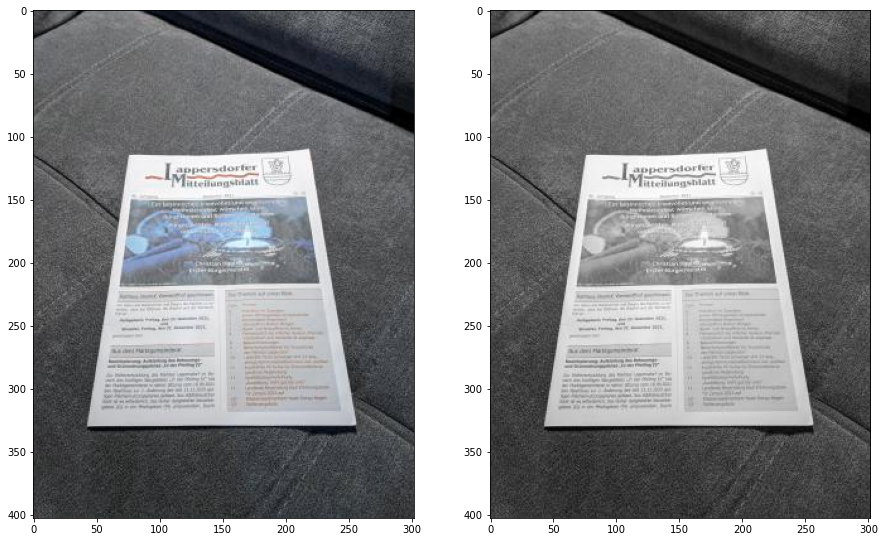

In [5]:
# Let's read the image
img = cv2.imread('Data/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

In [18]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness = np.clip(cornerness, 0 , 100000)

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1a60a820640>)

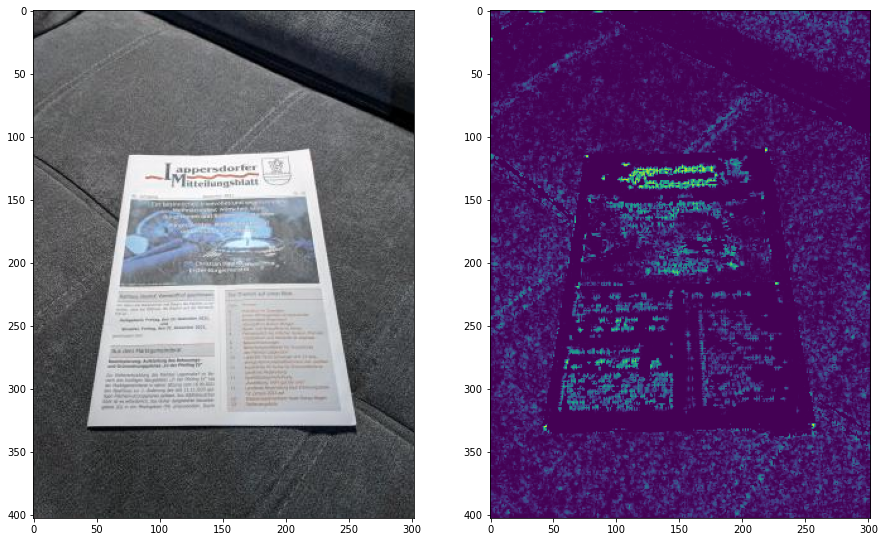

In [29]:
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)
#print(cornerness[100:120,50:100])

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1a609e91460>)

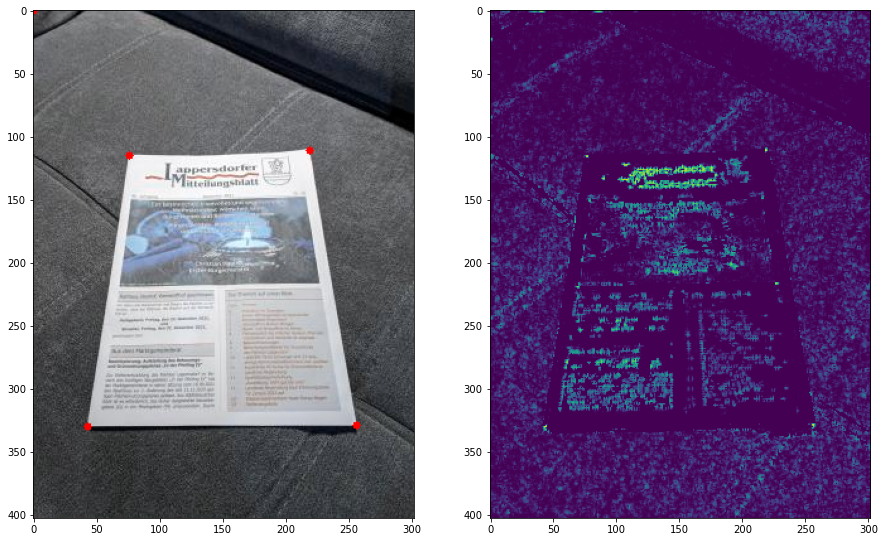

In [36]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size:quad_size*2 + 1]
        quad_bottom_left = block[quad_size:quad_size*2 + 1, 0:quad_size]
        quad_bottom_right = block[quad_size:quad_size*2 + 1, quad_size:quad_size*2 + 1]
        
        # Top-left corner
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        if descriptor > th_top_left:
            th_top_left = descriptor
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                    np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
            
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                    np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                    np.mean(quad_bottom_right) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

<h2>Questions</h2>
<b>1. Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?</b><br>
<i>We can say that each pixel of image taken by 1mpx cam ~ [3x4] matrix of pixels on image by 12mpx cam<br>
So this pixel can represent a smooth line on highres image instead of a corner on lowres. And we will lost a corner. But on other side we'll reveal small corners which we can not see on lowres image</i><br><br>
<b>2. If we increased the resolution of the camera, what would you change in the current algorithm?</b><br>
<i>The corners of piece of paper rather sharp, so I think it will not be a proplem even on larger resolution. But if resolution will be big enough, and thickness of letters on image became > 7px. We can get a lot of corners=)
In that case we can play with descriptor - increase it's size for example. But the best way imho use additional algorythm which can mark foreground/ background pixels for example. Using it we can check if corner is on the foreground/background border and say for sure if that corner is a corner of the document</i><br><br>

<h2>Thanks for viewing!</h2> ❤️️